## Preprocessing

In [157]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import preprocessing
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
print(os.listdir("./data"))

['mturk_100.csv', 'details_rbauct_concat.txt', 'embedding_5246.pkl', 'details_rbauction_raw.csv', 'Skid_Steer_Duke_Data2.xlsx', 'df_rbauct_5246_test.csv', '.ipynb_checkpoints', 'df_rbauct_transformed_test.csv', 'text_parts', 'sample_result_100', 'skid_steer_color_score.csv', 'df_rbauct_transformed_train.csv', 'mturk_96.csv', 'df_rbauct_5246_train.csv', 'Skid_steer_large.csv']


In [105]:
tabular_data = "./data/Skid_Steer_Duke_Data2.xlsx"
df = pd.read_excel(tabular_data)

df['Unique_ID'] = df[['Source','item#']].apply(lambda x: '_'.join(x),axis = 1)
color = pd.read_csv('./data/skid_steer_color_score.csv')
final_df = pd.merge(df, color,on='Unique_ID',how='inner')

df = final_df.filter(['Unique_ID','Make','Model','Winning_Bid','Hours_Final','Age_at_sale','score','Bucket','Engine','Tires','Transmission'], axis = 1)
df = df.rename(columns={
    'Unique_ID': "unique_id",
    'Make': 'make',
    'Model':'model',
    'Hours_Final': "hours_final",
    'Winning_Bid': "winning_bid",
    'Age_at_sale': "age_at_sale",
    'Bucket': "bucket",
    'Engine': "engine",
    'Tires': "tires",
    'Transmission': "transmission",
    'details remaining':"datails"
})

In [106]:
df.head()

,unique_id,make,model,winning_bid,hours_final,age_at_sale,score,bucket,engine,tires,transmission
0,rbauction_10199737,CATERPILLAR,272C 2 SPD HIGH FLOW,18500,4695.0,6.0,37.880233,NaN,NaN,NaN,NaN
1,rbauction_10323508,BOBCAT,751,7000,4675.0,18.0,14.743169,bkt,NaN,NaN,NaN
2,rbauction_10544103,CATERPILLAR,252B3 2 SPD,22000,4047.0,6.0,34.750538,bkt,NaN,solid tires,NaN
3,rbauction_10612921,DEERE,328D,18000,1370.0,6.0,32.387521,bkt,NaN,solid tires,NaN
4,rbauction_10533374,BOBCAT,S750 2 SPD,34000,1531.0,6.0,22.688279,bkt,NaN,NaN,NaN


In [107]:
### removal
# remove duplicant
duplicated_item = [item for item, count in Counter(df["unique_id"]).items() if count > 1]
df = df[~df['unique_id'].isin(duplicated_item)]

# remove special image
df = df[df['unique_id'] != "rbauction_10525632"]

In [108]:
df.isnull().sum(axis=0) # use mean imputation, use a more advanced imputation method (hours_final, age_at_sale)

unique_id          0
make               0
model              0
winning_bid        0
hours_final      494
age_at_sale      379
score              0
bucket          1044
engine          4239
tires           3653
transmission    5107
dtype: int64

In [109]:
### winning_bid

# log-transform
df["winning_bid"] = np.log(df["winning_bid"])

# standard scale
mm_scaler_price = preprocessing.StandardScaler()
df["winning_bid"] = mm_scaler_price.fit_transform(df["winning_bid"].to_numpy().reshape(-1, 1))

In [63]:
## Iterative imputor didn't work as well

# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer

# # Initialize IterativeImputer
# imp = IterativeImputer(max_iter=10, random_state=0)

# df[['hours_final','age_at_sale']] = imp.fit_transform(df[['hours_final','age_at_sale']])

In [64]:
# print('Train check')
# print(df[['hours_final','age_at_sale']].isna().sum())

Train check
hours_final    0
age_at_sale    0
dtype: int64


In [110]:
### hours_final

# exclude invalid values
df["hours_final"]


# impute nan with median and new binary indicator
# df["hours_final"] = df["hours_final"].str.replace(",", "")
# df["hours_final"] = df["hours_final"].astype(float)
df.insert(3, column="hours_final_nan", value=df["hours_final"].isna().astype(int))
df.loc[df["hours_final"].isna(), "hours_final"] = df["hours_final"].median(skipna=True)
df = df[df['hours_final'] < 40000]

# log transform
df["hours_final"] = np.log(df["hours_final"])

# normalize
std_scaler_hour = preprocessing.StandardScaler()
df["hours_final"] = std_scaler_hour.fit_transform(np.array(df["hours_final"]).reshape(-1, 1))

In [111]:
### age_at_sale

# impute nan with median and new binary indicator
# df["age_at_sale"] = df["age_at_sale"].astype(float)
df.insert(5, column="age_at_sale_nan", value=df["age_at_sale"].isna().astype(int))
df.loc[df["age_at_sale"].isna(), "age_at_sale"] = df["age_at_sale"].median(skipna=True)

# normalize
std_scaler_age = preprocessing.StandardScaler()
df["age_at_sale"] = std_scaler_age.fit_transform(np.array(df["age_at_sale"]).reshape(-1, 1))

In [112]:
### score

std_scaler_score = preprocessing.StandardScaler()
df["score"] = std_scaler_score.fit_transform(np.array(df["score"]).reshape(-1, 1))

In [113]:
### 42 makes
df['make'] = df['make'].replace({'BOB CAT': 'BOBCAT', 'BOCAT': 'BOBCAT'})
df['make'] = df['make'].replace({'NEW  HOLLAND': 'NEW HOLLAND'})
df['make'] = df['make'].replace({'A S V': 'ASV'})
df['make'] = df['make'].replace({'CASE IH': 'CASE','JI CASE':'CASE'}) # they seems to be the same company
df['make'] = df['make'].replace({'WACKER': 'WACKER NEUSON'})
df['make'] = df['make'].replace({'THOMAS PRO TOUGH': 'THOMAS'})
df['make'] = df['make'].replace({'SCATTRAK': 'SCAT TRAK', 'SCAT TRACK':'SCAT TRAK'}) # assume they come from same company
df['make'] = df['make'].replace({'DOOSAN DAEWOO':'DAEWOO'})
df['make'] = df['make'].replace({'TAKEUCHI MFG':'TAKEUCHI'})
df['make'] = df['make'].replace({'HYDRA-MAC':'HYDRAMAC'})
df['make'] = df['make'].replace({'POWEHOUSE PRO': 'POWERHOUSE'})
df['make'] = df['make'].replace({'MERTZ': 'BOXER'}) # assumption after observation

In [114]:
# group by make, and see model difference, how to do a submodel for each category??
df.groupby(['make'])['model'].unique()

make
ALLU                                                     [DH 3-17]
ASV                          [POSI-TRAC MD-70, 4520, RC85, P T-70]
BOBCAT           [751, S750 2 SPD, S150, S185, S770, S650, S250...
CASE             [85XT, SV300, 450, SR150, 450 SERIES III, SV30...
CATERPILLAR      [272C 2 SPD HIGH FLOW, 252B3 2 SPD, 262, 216B,...
CLARK                                                        [722]
DAEWOO           [460 PLUS, 440 PLUS, 1760XL, DSL801, DSL8D1, 6...
DEERE            [328D, 318D, 320D, 250, 318D 2 SPD, 324E 2 SPD...
DITCH WITCH                  [SK500, R300 ZAHN WALK BEHIND, SK755]
DOOSAN                                        [470 PLUS, 450 PLUS]
GALLAGHER                                              [SOLAR S17]
GEHL             [4640, 4240E, 5640, 7810, 4840, 5635, V400 2 S...
HYDRAMAC                                       [2650, 1700, 2650D]
HYUNDAI                                                 [HSL850-7]
IHI                                               [AS34 H

In [115]:
df.reset_index(drop=True, inplace=True)

In [116]:
## parts sentiments
def part_sentiment(part):
    part_sentiment = part + "_sentiment"
    df[part_sentiment] = ""
    analyzer = SentimentIntensityAnalyzer()
    list_indices = np.where(~df[part].isnull())[0]
    for indice in list_indices:
        sentence = df[part].tolist()[indice]
        if len(sentence)>100:  #pick up only very strong signals
            vs = analyzer.polarity_scores(sentence)
            lb = vs['compound']
            if lb >= 0.05:
                score = 1
            elif (lb > -0.05) and (lb < 0.05):
                score = 0
            else:
                score = -1
            df[part_sentiment][indice] = score
        else:
            df[part_sentiment][indice] = 0

    df[part_sentiment] = pd.to_numeric(df[part_sentiment]).fillna(0)

In [117]:
part_sentiment('engine')
part_sentiment('bucket')
part_sentiment('tires')
part_sentiment('transmission')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Collinearity issue

In [164]:
def heatmap_corr(df):
    sns.set(style="white")
    d = df
    # Compute the correlation matrix
    corr = d.corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 10))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
    square=True, linewidths=.5, cbar_kws={"shrink": .5})

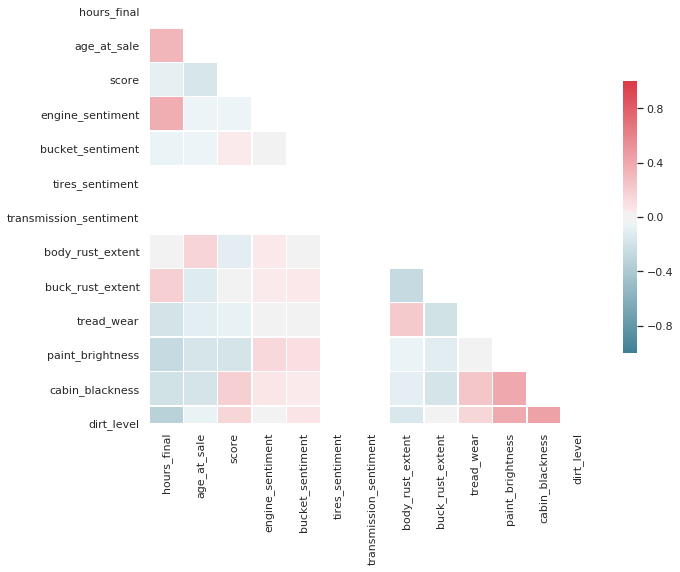

In [165]:
df_plot = df_join.drop(['unique_id','winning_bid','model','hours_final_nan','age_at_sale_nan','bucket_x','engine','tires','transmission','bucket_y', 'sun','blue_sky','grass','cloud_snow','outdoor'], axis=1)
heatmap_corr(df_plot)

## Model Comparisons
(the following use median imputation; **100 images** only for comparison)
1. MLR with hours_final, age_at_sale
2. MLR with hours_final, age_at_sale, make
3. MLR with hours_final, age_at_sale, make, all the annotations from MTRUK
4. H2O random forest regressor with all features involved (better to deal with categorical variables)

### 1. MLR with hours_final, age_at_sale (6117)

| Model | Parameters | Sample Size | R^2 |
| :- |-------------: | :-: | :-: |
| MLR | hours_final, age_at_sale | 6167 | 0.392 |
| MLR | hours_final, age_at_sale, **parts_sentiment** | 6167 | 0.395|
| MLR | hours_final, age_at_sale, **colorfulness_score** | 6167 | 0.396|
| MLR | hours_final, age_at_sale, **make** | 6167 | 0.434 |
| MLR | hours_final, age_at_sale | 96 | 0.431 |
| MLR | hours_final, age_at_sale, **make** | 96 | 0.570 |
| MLR | hours_final, age_at_sale, **make, mturk** | 96 | 0.633 |
| MLR | hours_final, age_at_sale, **make, mturk, parts_sentiment, colorfulness** | 96 | 0.676 |
| H2o_Random_Forest | hours_final, age_at_sale, **make, mturk, parts_sentiment, colorfulness** | 96 | 0.897 (MSE) |

In [42]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [118]:
y = df['winning_bid']
X = df[['hours_final','age_at_sale']]

In [119]:
def OLS_model(X,y):
    train_features, valid_features, train_y, valid_y = train_test_split(X, y, test_size = 0.25, random_state=12)
    np.random.seed(1234)
    model = sm.OLS(train_y, train_features).fit()
# predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
    print(model.summary())

In [120]:
OLS_model(X,y)

                                 OLS Regression Results                                
Dep. Variable:            winning_bid   R-squared (uncentered):                   0.392
Model:                            OLS   Adj. R-squared (uncentered):              0.392
Method:                 Least Squares   F-statistic:                              1490.
Date:                Mon, 02 Mar 2020   Prob (F-statistic):                        0.00
Time:                        02:46:44   Log-Likelihood:                         -5451.5
No. Observations:                4625   AIC:                                  1.091e+04
Df Residuals:                    4623   BIC:                                  1.092e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

### + Test if engine_sentiment is significant (not quite significant)

In [121]:
# improve slightly
y = df['winning_bid']
X = df[['hours_final','age_at_sale','engine_sentiment','bucket_sentiment','tires_sentiment','transmission_sentiment']]

In [122]:
OLS_model(X,y)

                                 OLS Regression Results                                
Dep. Variable:            winning_bid   R-squared (uncentered):                   0.395
Model:                            OLS   Adj. R-squared (uncentered):              0.394
Method:                 Least Squares   F-statistic:                              602.0
Date:                Mon, 02 Mar 2020   Prob (F-statistic):                        0.00
Time:                        02:46:47   Log-Likelihood:                         -5441.5
No. Observations:                4625   AIC:                                  1.089e+04
Df Residuals:                    4620   BIC:                                  1.093e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1830: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


### + Adding colorfulness scores

In [123]:
# improve slightly
y = df['winning_bid']
X = df[['hours_final','age_at_sale','score']]

In [124]:
OLS_model(X,y)

                                 OLS Regression Results                                
Dep. Variable:            winning_bid   R-squared (uncentered):                   0.396
Model:                            OLS   Adj. R-squared (uncentered):              0.395
Method:                 Least Squares   F-statistic:                              1009.
Date:                Mon, 02 Mar 2020   Prob (F-statistic):                        0.00
Time:                        02:47:40   Log-Likelihood:                         -5436.8
No. Observations:                4625   AIC:                                  1.088e+04
Df Residuals:                    4622   BIC:                                  1.090e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

### 2. MLR with hours_final, age_at_sale and make (6117)

In [125]:
y = df['winning_bid']
X = df[['hours_final','age_at_sale','make']]
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
make_encoded = sm.tools.categorical(X, col='make', drop=True)
X_encoded = pd.concat([X, make_encoded],axis=1).drop(['make'],axis=1)

In [126]:
OLS_model(X_encoded, y)

                            OLS Regression Results                            
Dep. Variable:            winning_bid   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     97.73
Date:                Mon, 02 Mar 2020   Prob (F-statistic):               0.00
Time:                        02:48:03   Log-Likelihood:                -5285.2
No. Observations:                4625   AIC:                         1.064e+04
Df Residuals:                    4588   BIC:                         1.088e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
hours_final      -0.0292      0.012     -2.512

- Interesting observations (with significant p values):
    - positive impact brands: CATERPILLAR, KUBOTA, WACKER NEUSON
    - negative impact brands: DAEWOO, DITCH WITCH, GEHL, KOMATSU, MATTSON, MUSTANG, NEW HOLLAND, SKYJACK, TEREX, THOMAS, TORO, VERMEER, VOLVO

### 3. MTRUK (96)

In [130]:
mturk_data = "./data/mturk_96.csv"
mturk = pd.read_csv(mturk_data)

In [131]:
# right join the dataframe with mturk_100, throw in mlr
# df.reset_index(drop=True, inplace=True)
df_join = pd.merge(df,mturk, on=['unique_id'], how='right')

In [132]:
# normalize
def normalize_scaler(col):
    std_scaler = preprocessing.StandardScaler()
    df_join[col] = std_scaler.fit_transform(np.array(df_join[col]).reshape(-1, 1))

num_col_list = ['body_rust_extent', 'buck_rust_extent','tread_wear','paint_brightness','cabin_blackness','dirt_level']
for col in num_col_list:
    normalize_scaler(col)

#### (1) MLR with hours_final, age_at_sale (96)

In [53]:
y = df_join['winning_bid']
X = df_join[['hours_final','age_at_sale']]

In [54]:
OLS_model(X, y)

                                 OLS Regression Results                                
Dep. Variable:            winning_bid   R-squared (uncentered):                   0.431
Model:                            OLS   Adj. R-squared (uncentered):              0.414
Method:                 Least Squares   F-statistic:                              26.48
Date:                Mon, 02 Mar 2020   Prob (F-statistic):                    2.74e-09
Time:                        02:30:55   Log-Likelihood:                         -89.703
No. Observations:                  72   AIC:                                      183.4
Df Residuals:                      70   BIC:                                      188.0
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

#### (2)  MLR with hours_final, age_at_sale and make (96)

In [55]:
y = df_join['winning_bid']
X = df_join[['hours_final','age_at_sale','make']]
make_encoded = sm.tools.categorical(X, col='make', drop=True)
X_encoded = pd.concat([X, make_encoded],axis=1).drop(['make'],axis=1)

In [56]:
OLS_model(X_encoded, y)

                            OLS Regression Results                            
Dep. Variable:            winning_bid   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     6.507
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           3.24e-07
Time:                        02:31:00   Log-Likelihood:                -78.462
No. Observations:                  72   AIC:                             182.9
Df Residuals:                      59   BIC:                             212.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
hours_final    -0.6033      0.176     -3.422      

#### (3) MLR with hours_final, age_at_sale and mturk data (96)

In [28]:
y = df_join['winning_bid']
X = df_join.drop(['unique_id','winning_bid','make','model','hours_final_nan','age_at_sale_nan','bucket_x','engine','tires','transmission'],axis=1)
# X = X.fillna(11)

In [29]:
OLS_model(X,y)

                                 OLS Regression Results                                
Dep. Variable:            winning_bid   R-squared (uncentered):                   0.559
Model:                            OLS   Adj. R-squared (uncentered):              0.433
Method:                 Least Squares   F-statistic:                              4.439
Date:                Mon, 02 Mar 2020   Prob (F-statistic):                    1.55e-05
Time:                        02:08:35   Log-Likelihood:                         -80.500
No. Observations:                  72   AIC:                                      193.0
Df Residuals:                      56   BIC:                                      229.4
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

#### (4) MLR with hours_final, age_at_sale, make, parts_sentiment, mturk data (96)

In [138]:
y = df_join['winning_bid']
X = df_join.drop(['unique_id','winning_bid','model','hours_final_nan','age_at_sale_nan','bucket_x','engine','tires','transmission','score','engine_sentiment','bucket_sentiment','tires_sentiment','transmission_sentiment'],axis=1)
make_encoded = sm.tools.categorical(X, col='make', drop=True)
X_encoded = pd.concat([X, make_encoded],axis=1).drop(['make'],axis=1)

In [139]:
OLS_model(X_encoded,y)

                            OLS Regression Results                            
Dep. Variable:            winning_bid   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     3.378
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           0.000177
Time:                        03:01:46   Log-Likelihood:                -74.364
No. Observations:                  72   AIC:                             198.7
Df Residuals:                      47   BIC:                             255.6
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
hours_final         -0.7535      0.244  

#### (5) MLR with everything

In [140]:
y = df_join['winning_bid']
X = df_join.drop(['unique_id','winning_bid','model','hours_final_nan','age_at_sale_nan','bucket_x','engine','tires','transmission'],axis=1)
make_encoded = sm.tools.categorical(X, col='make', drop=True)
X_encoded = pd.concat([X, make_encoded],axis=1).drop(['make'],axis=1)

In [141]:
OLS_model(X_encoded,y)

                            OLS Regression Results                            
Dep. Variable:            winning_bid   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     3.393
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           0.000158
Time:                        03:02:32   Log-Likelihood:                -69.930
No. Observations:                  72   AIC:                             195.9
Df Residuals:                      44   BIC:                             259.6
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
hours_final               -1

#### (5) H2O Random Forest Regressor

In [142]:
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

In [166]:
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,2 hours 36 mins
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.3
H2O cluster version age:,25 days
H2O cluster name:,H2O_from_python_deepecholiu_67i8j3
H2O cluster total nodes:,1
H2O cluster free memory:,846 Mb
H2O cluster total cores:,1
H2O cluster allowed cores:,1
H2O cluster status:,"locked, healthy"


In [167]:
h2o_df = H2OFrame(df_join)

def factorize(col):
    h2o_df[col] = h2o_df[col].asfactor()
    
cat_col_list = ['bucket_y', 'sun','blue_sky','grass','cloud_snow','outdoor']
for col in cat_col_list:
    factorize(col)

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,unique_id,make,model,hours_final_nan,winning_bid,age_at_sale_nan,hours_final,age_at_sale,score,bucket_x,engine,tires,transmission,engine_sentiment,bucket_sentiment,tires_sentiment,transmission_sentiment,bucket_y,sun,blue_sky,grass,cloud_snow,outdoor,body_rust_extent,buck_rust_extent,tread_wear,paint_brightness,cabin_blackness,dirt_level
type,string,enum,enum,int,real,int,real,real,real,enum,enum,enum,enum,enum,int,int,int,enum,enum,enum,enum,enum,enum,real,real,real,real,real,real
mins,NaN,,,0.0,-2.061765271448536,0.0,-1.737345266065624,-1.4745457931895276,-2.2816507237266177,,,,,,-1.0,0.0,0.0,,,,,,,-2.1324907336263013,-0.5866561988897826,-2.686576835431791,-2.0568320671766647,-3.138335072620883,-3.070659946546774
mean,NaN,,,0.010416666666666666,0.1976256569115189,0.08333333333333333,0.10895263485110987,-0.06390212686235516,-0.16470685706780436,,,,,,-0.010416666666666666,0.0,0.0,,,,,,,5.551115123125783e-17,-2.949029909160572e-17,-2.393918396847994e-16,5.377642775528102e-17,7.979727989493313e-17,5.204170427930421e-17
maxs,NaN,,,1.0,2.3557434498463152,1.0,0.9942494464409128,3.4678553735042152,2.163012493092647,,,,,,0.0,0.0,0.0,,,,,,,2.4288536625015964,2.1508730217436347,1.912250594519768,1.6035829044041414,1.8920246224988349,1.9134792869969377
sigma,NaN,,,0.10206207261596575,1.1474234863396495,0.27783625115549687,0.514106152782626,1.0945856050739948,0.9594571039600708,,,,,,0.10206207261596575,0.0,0.0,,,,,,,1.0052493799000688,1.0052493799000692,1.0052493799000692,1.0052493799000692,1.005249379900069,1.0052493799000692
zeros,0,,,95,0,88,0,0,0,,,,,,95,96,96,,,,,,,0,0,0,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,bigiron_AF1307,BOBCAT,T750,0.0,1.8538668159822111,0.0,-0.08522795445955443,-1.4745457931895276,-0.7950086262653282,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0,1,1,0,1,1,-0.8879220034413361,2.1508730217436347,-1.0934495502291723,1.4585724673547218,0.06217988326591278,-0.9346002750280402
1,bigiron_AF1274,BOBCAT,T590 T4,0.0,1.8358145900664344,0.0,-0.5051892154106192,-1.4745457931895276,-0.8037889187345136,"74"" Bucket",Kubota Engine,"16"" Tracks",nan,0.0,0.0,0.0,0.0,1,1,1,0,0,1,-1.3048525280532994,-0.4851740550541802,0.14387930794486126,0.14029576690545184,0.5213544058449606,0.9664928326236324
2,bigiron_AE6184,GEHL,SL5625,0.0,-1.408953531942828,0.0,0.44920369930958515,1.490894906826718,-0.389997695980042,"66"" Bucket",60 HP Perkins Diesel Engine,Tires: 12X16.5,Hydrostatic Transmission,0.0,0.0,0.0,0.0,0,1,0,0,0,1,0.7735772513555925,2.1508730217436347,-0.5624071218282997,-1.7668111930778252,-1.0823297476400722,-1.169566838895101


In [168]:
train,test,valid = h2o_df.split_frame(ratios=[.8, .1])

feature = [e for e in df_join.columns.to_list() if e not in ('unique_id', 'model','hours_final_nan','winning_bid','age_at_sale_nan','bucket_x','engine','tires','transmission')]
target = 'winning_bid'

In [169]:
model = H2ORandomForestEstimator(ntrees=100, max_depth=10, sample_rate = 0.8, mtries=3, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [170]:
predict = model.predict(test)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [171]:
print(model)

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1583114951691_3


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,100.0,100.0,77009.0,9.0,10.0,9.98,39.0,70.0,56.65




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.7898324650944513
RMSE: 0.888725190986759
MAE: 0.7202778560080167
RMSLE: NaN
Mean Residual Deviance: 0.7898324650944513

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2020-03-02 04:46:08,0.000 sec,0.0,NaN,NaN,NaN
1,,2020-03-02 04:46:08,0.016 sec,1.0,1.229797,0.871991,1.512401
2,,2020-03-02 04:46:08,0.023 sec,2.0,1.162234,0.858348,1.350787
3,,2020-03-02 04:46:08,0.030 sec,3.0,1.156572,0.909497,1.337658
4,,2020-03-02 04:46:08,0.039 sec,4.0,1.215039,0.965810,1.476319
5,,2020-03-02 04:46:08,0.049 sec,5.0,1.204685,0.919465,1.451266
6,,2020-03-02 04:46:08,0.065 sec,6.0,1.213598,0.918485,1.472820
7,,2020-03-02 04:46:08,0.068 sec,7.0,1.164610,0.902489,1.356318
8,,2020-03-02 04:46:08,0.079 sec,8.0,1.196100,0.925008,1.430654
9,,2020-03-02 04:46:08,0.085 sec,9.0,1.141688,0.872258,1.303452



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,age_at_sale,1852.077515,1.000000,0.210044
1,hours_final,1244.915527,0.672172,0.141186
2,make,1024.147949,0.552973,0.116149
3,paint_brightness,946.377136,0.510981,0.107329
4,cabin_blackness,797.913879,0.430821,0.090491
5,score,608.231018,0.328405,0.068979
6,body_rust_extent,604.499146,0.326390,0.068556
7,dirt_level,557.688354,0.301115,0.063247
8,tread_wear,361.822174,0.195360,0.041034
9,buck_rust_extent,249.112915,0.134505,0.028252


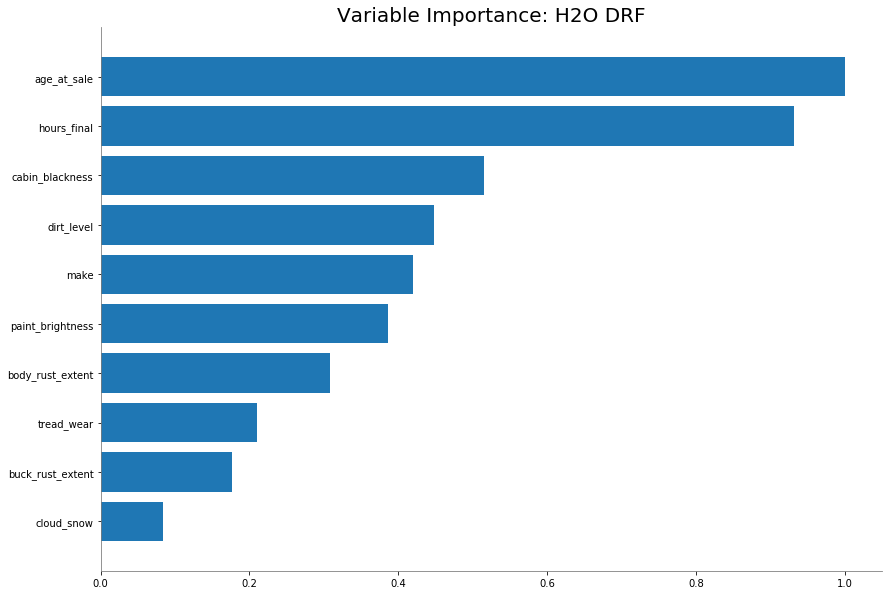

In [39]:
model.varimp_plot()

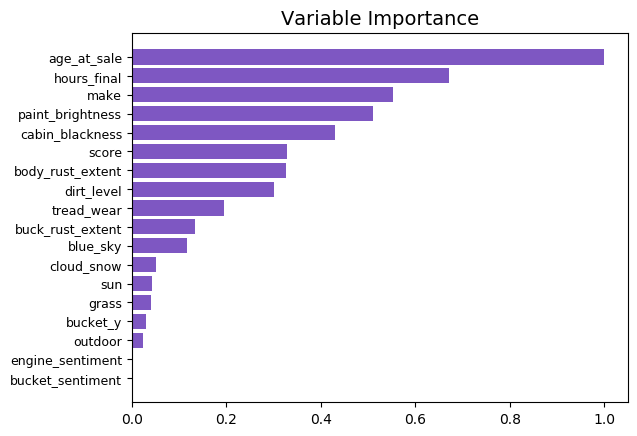

In [191]:
import matplotlib.pyplot as plt
plt.rcdefaults()
csfont = {'fontname':'sans-serif'}
hfont = {'fontname':'sans-serif'}
fig, ax = plt.subplots()
variables = model._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = model._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance, align='center', color='#7e57c2', ecolor=None)
ax.set_yticks(y_pos)
ax.set_yticklabels(variables,**csfont,fontsize = 9)
ax.invert_yaxis()
# ax.set_xlabel('Scaled Importance',**csfont)
ax.set_title('Variable Importance',**hfont, fontsize = 14)
plt.show()